In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import calendar

In [ ]:
#!c:/Users/toy_3/AppData/Local/Programs/Python/Python39/python.exe -m pip install pandas plotly dash

In [13]:
data = pd.read_csv("actual_pred_2.csv")
#data.head()
#data.tail()
'''data.info
data.isnull().sum()
data.columns
print(data['MONTH'].unique())
print(data.isnull().sum())
print(len(data['AMP'].unique()))
data.shape
'''
gdf = gpd.read_file("districts.shp")

data['PROV'] = data['PROV'].astype(str)
data['AMP'] = data['AMP'].astype(str)
gdf['PROV'] = gdf['ADM1_EN'].astype(str)
gdf['AMP'] = gdf['ADM2_EN'].astype(str)

districts = gdf[['AMP', 'PROV']]
districts.drop_duplicates(inplace=True)
print(districts.shape)

dat = districts.merge(data, on = ['PROV', 'AMP'], how = 'left')
print(dat.shape)# 32 diff

rows_to_expand = dat[dat['caseper100k'].isna()]
#print(rows_to_expand)

new_rows = []

for _, row in rows_to_expand.iterrows():
    for month in range(1, 13):
        new_row = row.copy()
        new_row['MONTH'] = month
        new_row['caseper100k'] = 0
        new_row['Pred'] = 0
        new_rows.append(new_row)

    
new_rows_df = pd.DataFrame(new_rows)
#print(new_rows_df)

df_filtered = dat[dat['caseper100k'].notna()]
df_final = pd.concat([df_filtered, new_rows_df], ignore_index = True)

df_final['MAE'] = abs(df_final['Pred'] - df_final['caseper100k'])

mean_df = df_final.groupby(['AMP', 'PROV'])[['caseper100k', 'Pred', 'MAE']].mean().reset_index()


(927, 2)
(12296, 5)


C:\Windows\Temp\ipykernel_816\1700923884.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  districts.drop_duplicates(inplace=True)


In [16]:
def plot_comparison_heatmap(df, gdf,
                            columns=['caseper100k', 'Pred', 'MAE'],
                            titles=None,
                            save_path='comparison_heatmap.png',
                            cmap12='Reds', cmap3 = 'Greens_r', reverse_cmap=False):
    
    
    df['PROV'] = df['PROV'].astype(str)
    df['AMP'] = df['AMP'].astype(str)

    gdf_merged = gdf.merge(df, on=['PROV', 'AMP'], how='left')

    # find common length of color scale
    all_values = pd.concat([gdf_merged[col] for col in columns])
    common_vmin = all_values.min()
    common_vmax = all_values.max()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 10))

    # Plot first column
    for i, column in enumerate(columns):
        title = titles[i] if titles and i < len(titles) else f"{column}" 
        
        if column == 'MAE':
            vmin = gdf_merged[column].quantile(0.05)
            vmax = gdf_merged[column].quantile(0.95)
            cmap = cmap3
        else:
            vmin = common_vmin
            vmax = common_vmax
            cmap = cmap12

        gdf_merged.plot(column = column,
                        cmap = cmap,
                        linewidth = 1,
                        edgecolor = 'black',
                        legend = True,
                        vmin = vmin,
                        vmax = vmax,
                        legend_kwds = {'label' : f"{column}",
                                       'shrink' : 0.5,
                                       'aspect' : 30,
                                       'orientation' : 'vertical'},
                                       ax=axes[i])
    
        axes[i].set_title(title, fontsize=14)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

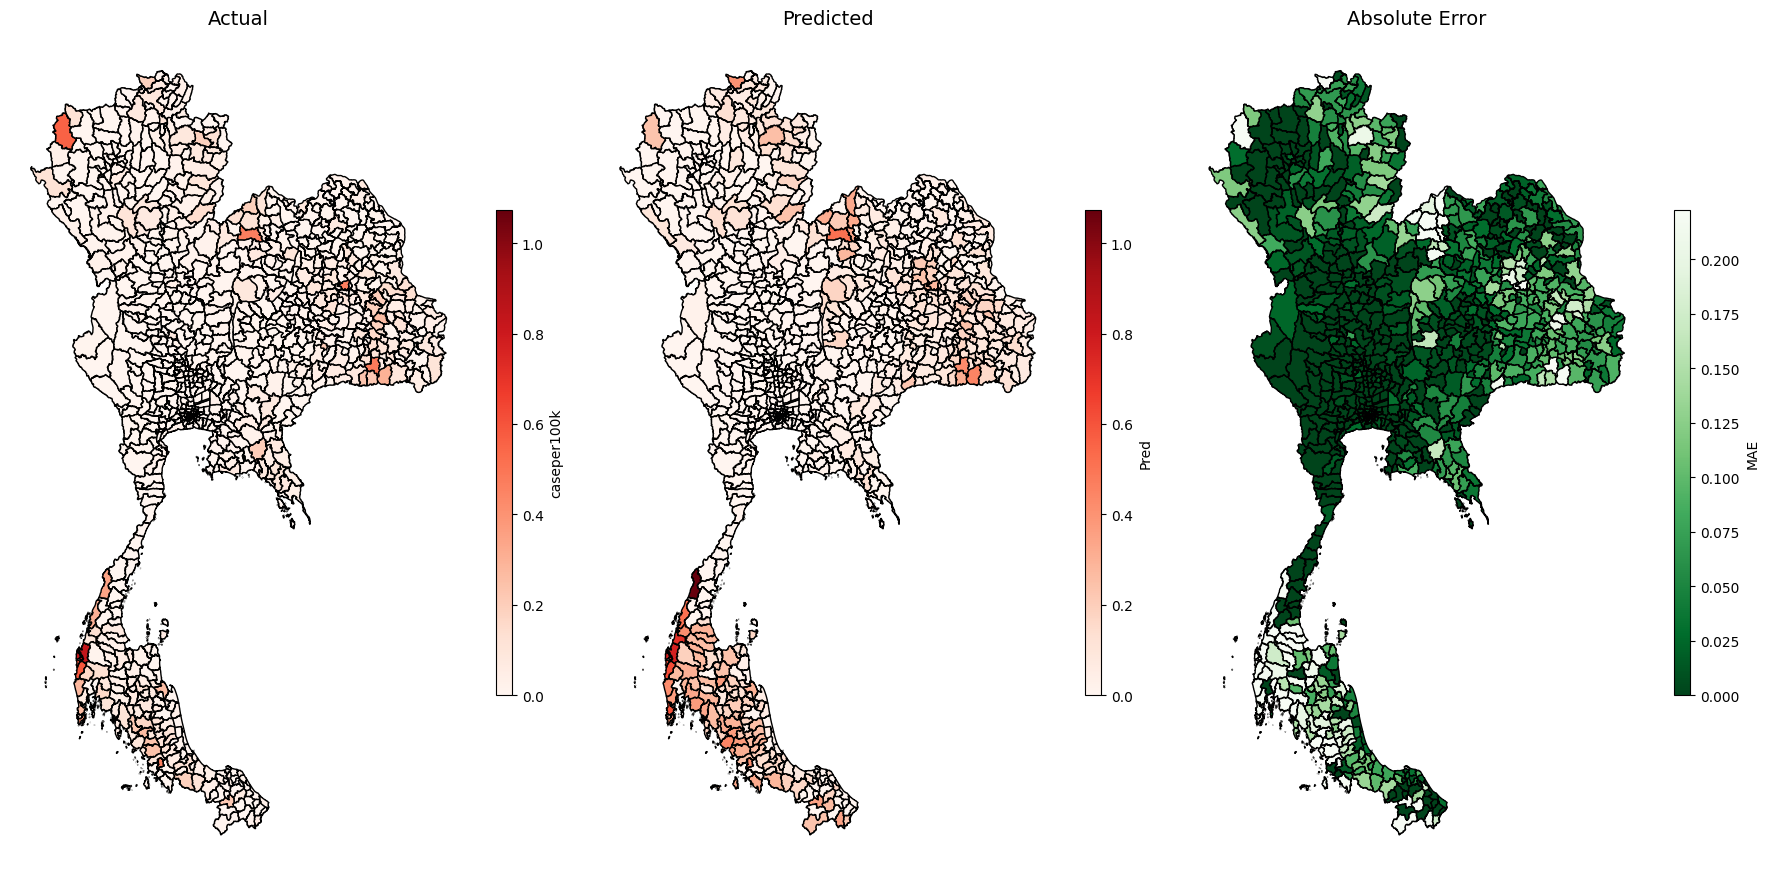

In [17]:
plot_comparison_heatmap(mean_df,
                            gdf,
                            columns = ['caseper100k', 'Pred', 'MAE'],
                            titles = ['Actual', 'Predicted', 'Absolute Error'],
                            save_path = "comparison_heatmap.png",
                            cmap12 = 'Reds',
                            cmap3 = "Greens_r")